In [ ]:
# Install the library
# %pip install pythae

In [22]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import model
import train
import lossfn
import plots
import util
from custom_dataset import CustomDataset

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
!nvidia-smi

Mon Jun  5 09:14:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   45C    P0    41W / 250W |  14531MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

## Dataset

In [2]:
data_path = './data/MDISC/small_dataset/samples_v2d_B_rhoz_512x512.pkl'
labels_path = './data/MDISC/small_dataset/samples_target.pkl'

width = 512

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              #transforms.Resize((width,width)),
                              #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                             ])
dataset = CustomDataset(data_path=data_path, labels_path=labels_path, transform=transform)

In [3]:
dataset[0][0].shape

torch.Size([1, 512, 512])

In [4]:
dataset[0][0].dtype, dataset[0][0].shape

(torch.float32, torch.Size([1, 512, 512]))

In [10]:
batch_size = 8
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

torch.Size([8, 1, 512, 512]) (8,)


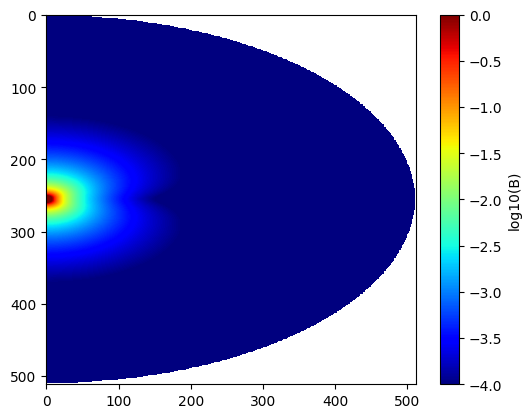

In [9]:
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    print(x.shape, y.shape)
    break

fig, ax = plt.subplots()
s = plt.imshow(np.log10(x[-1].cpu().detach().numpy().squeeze()), vmin=-4,
                vmax=0,
                cmap="jet")
plt.colorbar(s, label='log10(B)');

## Model

In [23]:
from model import VAE

In [24]:
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta = beta, device=device)

## Training Pipeline

In [25]:
from train import train_model

In [26]:
output_dir='my_model'
lr=1e-3
epochs=20

In [27]:
vae = train_model(vae, dataloader, lr=lr, epochs=epochs)

  5%|▌         | 1/20 [00:02<00:41,  2.20s/it]

Epoch: 1/20, Loss: nan


 10%|█         | 2/20 [00:03<00:26,  1.47s/it]

Epoch: 2/20, Loss: nan


 15%|█▌        | 3/20 [00:04<00:20,  1.22s/it]

Epoch: 3/20, Loss: nan


 20%|██        | 4/20 [00:05<00:18,  1.14s/it]

Epoch: 4/20, Loss: nan


 25%|██▌       | 5/20 [00:06<00:16,  1.08s/it]

Epoch: 5/20, Loss: nan


 30%|███       | 6/20 [00:07<00:14,  1.05s/it]

Epoch: 6/20, Loss: nan


 35%|███▌      | 7/20 [00:08<00:13,  1.02s/it]

Epoch: 7/20, Loss: nan


 40%|████      | 8/20 [00:09<00:12,  1.05s/it]

Epoch: 8/20, Loss: nan


 45%|████▌     | 9/20 [00:10<00:11,  1.02s/it]

Epoch: 9/20, Loss: nan


 50%|█████     | 10/20 [00:11<00:10,  1.00s/it]

Epoch: 10/20, Loss: nan


 55%|█████▌    | 11/20 [00:12<00:08,  1.01it/s]

Epoch: 11/20, Loss: nan


 60%|██████    | 12/20 [00:13<00:08,  1.02s/it]

Epoch: 12/20, Loss: nan


 65%|██████▌   | 13/20 [00:14<00:07,  1.02s/it]

Epoch: 13/20, Loss: nan


 70%|███████   | 14/20 [00:15<00:06,  1.03s/it]

Epoch: 14/20, Loss: nan


 75%|███████▌  | 15/20 [00:16<00:05,  1.03s/it]

Epoch: 15/20, Loss: nan


 80%|████████  | 16/20 [00:17<00:04,  1.02s/it]

Epoch: 16/20, Loss: nan


 85%|████████▌ | 17/20 [00:18<00:02,  1.01it/s]

Epoch: 17/20, Loss: nan


 90%|█████████ | 18/20 [00:19<00:01,  1.00it/s]

Epoch: 18/20, Loss: nan


 95%|█████████▌| 19/20 [00:20<00:01,  1.04s/it]

Epoch: 19/20, Loss: nan


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

Epoch: 20/20, Loss: nan


In [69]:
# save the model    
from util import save_model, load_model
#save_model(vae, model_path=f'./my_model/vae_beta={beta}.pth')
vae = load_model(vae, model_path='./my_model/vae_beta=1.0.pth')

## Plot latent vectors
Let’s plot the latent vector representations of a few batches of data.

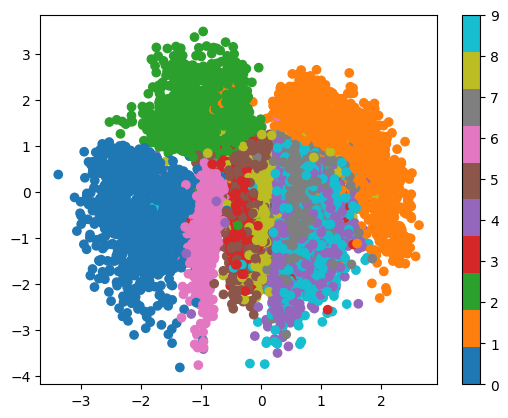

In [70]:
from plots import plot_latent
plot_latent(vae, data)

## Visualizing reconstructions

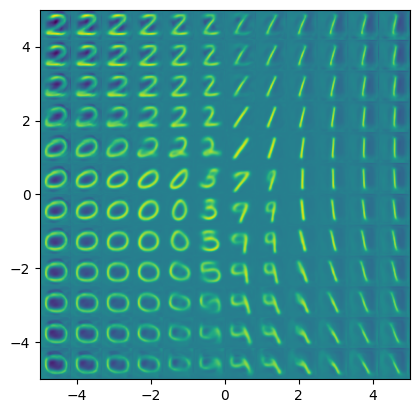

In [165]:
from plots import reconstruct, plot_reconstructed
plot_reconstructed(vae, width=32, z0=(-5, 5), z1=(-5, 5), n_img=12)

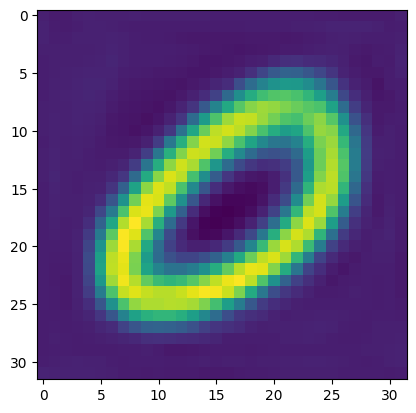

In [167]:
reconstruct(vae.eval(), x_2, width)

## Visualizing interpolations

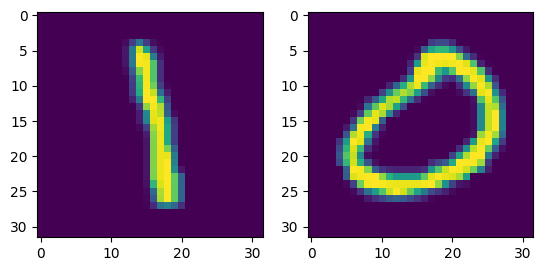

In [169]:
for x,y in data:
    x_1 = x[y == 1][1].unsqueeze(dim=1).to(device) # find a 1
    x_2 = x[y == 0][1].unsqueeze(dim=1).to(device) # find a 0
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x_1.cpu().detach().numpy().squeeze())
    ax[1].imshow(x_2.cpu().detach().numpy().squeeze())
    break

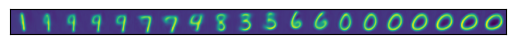

In [170]:
from plots import interpolate, interpolate_gif
interpolate(vae.eval(), x_1, x_2, width, n_img=20)

In [176]:
interpolate_gif(vae, width, "vae", x_1, x_2)